In [15]:
from functools import partial
import os, sys
import numpy as np
from numpy import log, exp, sqrt
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *
from src.train import *
from src.model import Environment, Agent, ReplayBuffer

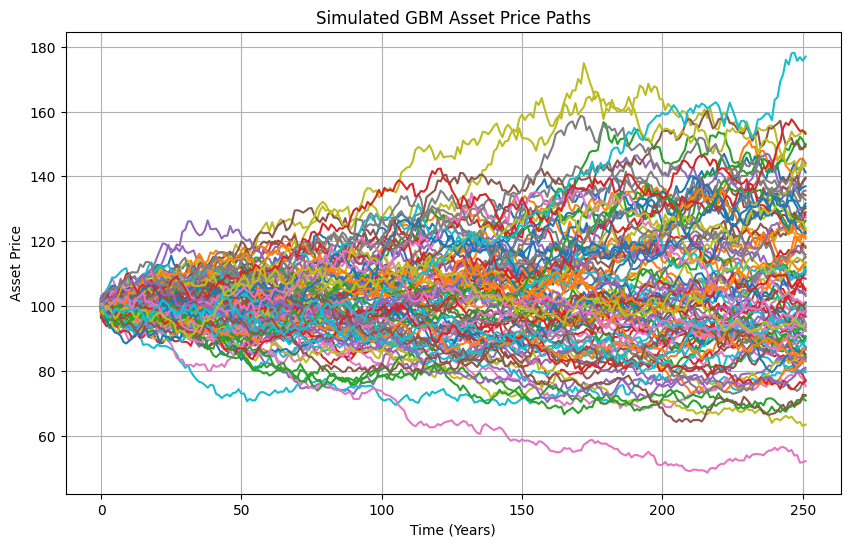

In [16]:
nsim = 100          
nstep = 252       
t1 = 0            
t2 = 1.0          
s_0 = 100        
r = 0.04         
q = 0.0          
v = 0.2          

price_paths = generate_gbm_paths(nsim, nstep, t1, t2, s_0, r, q, v)
#price_paths = generate_heston_paths(nsim, nstep, t1, t2, s_0, r, q, v, theta, rho, kappa, sigma, **kwargs)

plt.figure(figsize=(10, 6))
plt.plot(price_paths.T)
plt.title('Simulated GBM Asset Price Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

In [17]:
K = 100 
price_paths = generate_gbm_paths(nsim=15000, nstep=nstep, t1=t1, t2=t2, s_0=s_0, r=r, q=q, v=v)
env = Environment(price_paths=price_paths, K=K, t1=t1, t2=t2, r=r, option_type="put")
obs = env.reset()
print(f"Initial Observation: {obs}")

# done = False
# step_count = 0
# while not done:
#     action = env.action_space.sample() 
#     obs, reward, done, info = env.step(action)
#     step_count += 1
#     print(f"Step {step_count}: Obs={obs}, Reward={reward}, Done={done}, Info={info}")


Initial Observation: [9.9878395e+01 1.0000000e+00 9.9878395e-01 0.0000000e+00 0.0000000e+00
 1.7475765e-02]


In [18]:
agent = Agent(
    obssize=6,  
    actsize=2,
    hidden_dim=128,
    depth=2,
    lr=1e-3,
    buffer_size=10000,
    batch_size=128,
    gamma=0.999,
    eps_start=1.0,
    eps_min=0.01,
    eps_decay=0.9995
)
agent.initialize_buffer(env, steps=100000)  

Episode 0/10000, Total Reward: 0.05, Moving Avg Reward: 0.05, Moving Avg Holding: 1.00, Epsilon: 0.9990
Episode 100/10000, Total Reward: 0.94, Moving Avg Reward: 0.75, Moving Avg Holding: 2.04, Epsilon: 0.8581
Episode 200/10000, Total Reward: 0.06, Moving Avg Reward: 0.81, Moving Avg Holding: 2.53, Epsilon: 0.7192
Episode 300/10000, Total Reward: 1.79, Moving Avg Reward: 0.83, Moving Avg Holding: 2.87, Epsilon: 0.5927
Episode 400/10000, Total Reward: 0.00, Moving Avg Reward: 1.12, Moving Avg Holding: 3.35, Epsilon: 0.4768
Episode 500/10000, Total Reward: 0.78, Moving Avg Reward: 0.78, Moving Avg Holding: 4.49, Epsilon: 0.3623
Episode 600/10000, Total Reward: 1.43, Moving Avg Reward: 0.80, Moving Avg Holding: 5.26, Epsilon: 0.2649
Episode 700/10000, Total Reward: 0.07, Moving Avg Reward: 1.00, Moving Avg Holding: 6.93, Epsilon: 0.1782
Episode 800/10000, Total Reward: 1.82, Moving Avg Reward: 1.61, Moving Avg Holding: 12.70, Epsilon: 0.0898
Episode 900/10000, Total Reward: 0.00, Moving A

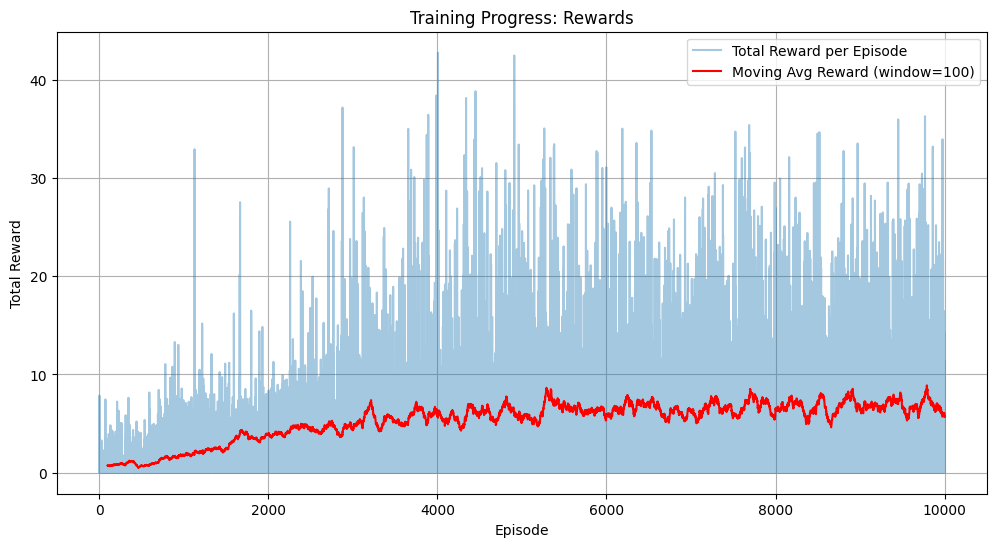

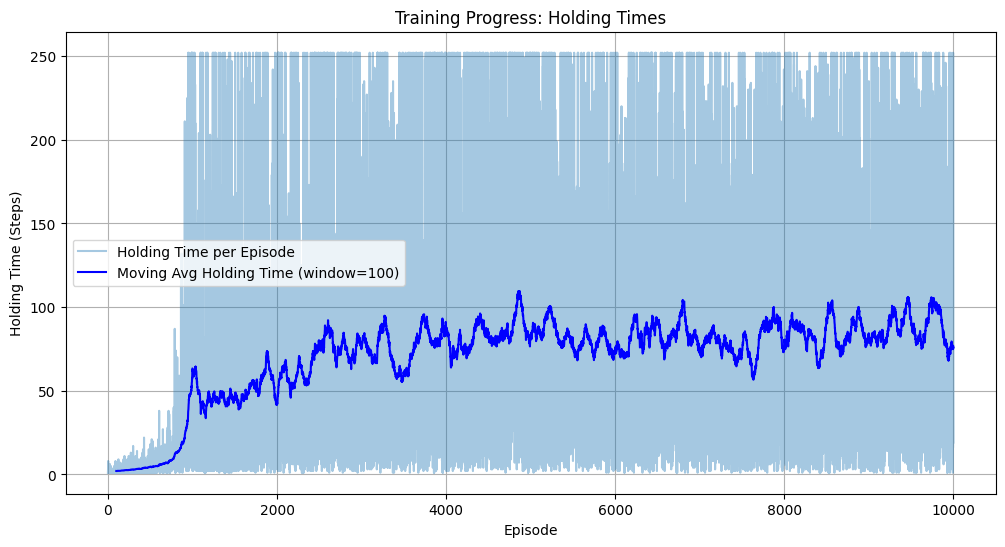

In [19]:
# Train the agent
episodes = 10000
update_target_every = 50
rewards = train(agent, env, episodes, update_target_every)


In [20]:
np.mean(rewards[:-1000])

nan

In [21]:
def plot_exercise_boundary(agent, env, n_paths=100, strike_price=150):
    """
    Visualize the early exercise boundary for a sample of paths.
    """
    plt.figure(figsize=(12, 8))
    exercise_points = []

    for i in range(n_paths):
        state = env.reset()
        path = [state[0]]  # Asset prices
        times = [0]  # Time steps
        done = False

        while not done:
            # Select an action using a greedy policy
            action = agent.act(state)

            if action == 1:  # Exercise
                exercise_points.append((env.current_step * env.dt, state[0]))  # Record exercise point
                done = True
            else:
                obs, _, done, _ = env.step(0) 
                state = obs  
                path.append(state[0]) 
                times.append(env.current_step * env.dt)

        # Plot the asset price path
        plt.plot(times, path, color='blue', alpha=0.3)

    # Plot exercise points if available
    if exercise_points:
        ex_times, ex_prices = zip(*exercise_points)
        plt.scatter(ex_times, ex_prices, color='red', label='Exercise Points')

    # Add strike price for reference
    plt.axhline(y=strike_price, color='green', linestyle='--', label='Strike Price')

    plt.title(f"Early Exercise Boundary Visualization ({n_paths} Paths)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.grid(True)
    plt.show()

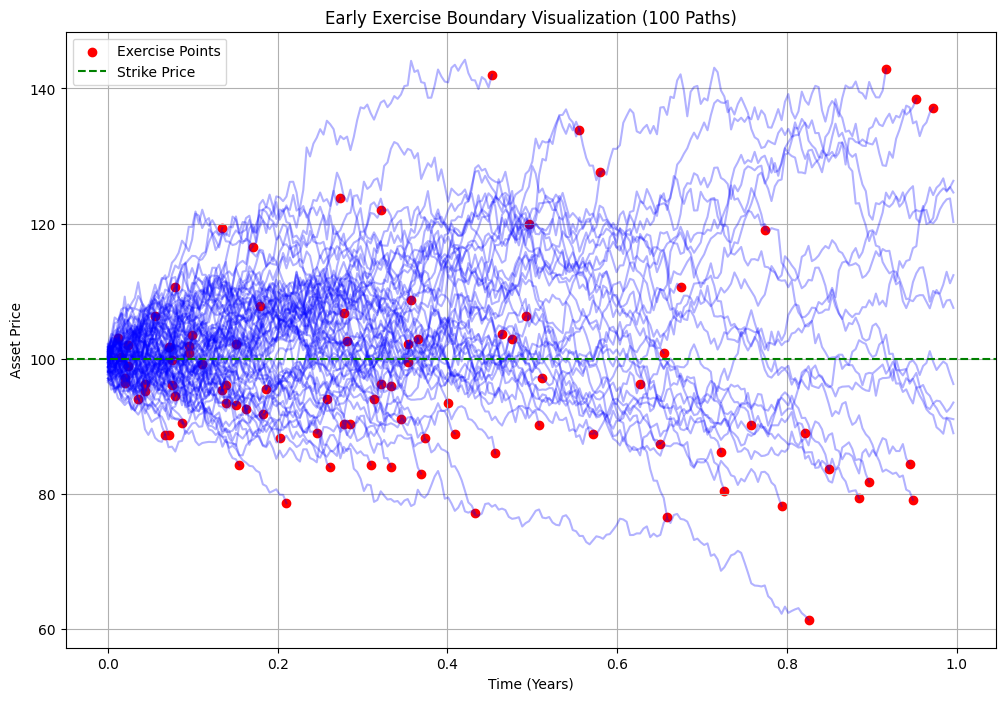

In [22]:
plot_exercise_boundary(agent, env, n_paths=100, strike_price=K)

In [23]:
def estimate_option_price(agent, env, n_paths=10000):
    """
    Estimate the option price using the trained agent.
    """
    total_rewards = []

    for _ in range(n_paths):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    # Return the average reward as the estimated price
    return np.mean(total_rewards)

In [24]:
estimate_option_price(agent, env, n_paths = 1000)

7.065971393298595

In [25]:
def get_mc_price(prices, t1, t2, h, k, r):
    # Takes as input prices array from call to generate_xxx_paths()
    # t1, t2, r must be identical from aformentioned function call
    # h := payoff function (Callable)
    # k := strike price (int)
    nstep = prices.shape[1]
    dt = (t2 - t1) / nstep

    values = np.zeros_like(prices)
    values[:, -1] = h(prices[:, -1], k)

    for t in range(nstep-2, -1, -1):
        values[:, t] = np.maximum(values[:, t], exp(-r*dt)*values[:, t+1])

    return exp(-r*dt)*np.mean(values[:, 0])


In [26]:
def put_payoff(S, K):
    return np.maximum(K - S, 0)

mc_put_price = get_mc_price(price_paths, t1, t2, put_payoff, K, r)

mc_put_price

5.9069344999451685